* This notebook was made to look at tidal heights at Steveston, Deas Island channel, New Westminster and Mission in the deepening river channel case.

In [1]:
from salishsea_tools import (nc_tools,viz_tools,stormtools,tidetools,)
from nowcast.figures import shared
import datetime
import glob
import os
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [2]:
sites = {
    'Sandheads': {
        'lat': 49.10,
        'lon': -123.30,
        'i' : 77, #426 start from 349 fortran start from 350
        'j' : 34, #293 start from 259 fortran start from 260
   
    },
    'Steveston':{
        'lat': 49.1057,
        'lon': -123.1032,
        'i' :  75,#424
        'j' :  53,#312
    },
    'Deas Island':{
        'lat' : 48.12,
        'lon' : -123.07,
        'i' : 65,#414,
        'j' : 69,#328
    },    
    'New Westminster': {
        'lat': 49.21,
        'lon': -122.89,
        'i': 69,#418,
        'j': 106,#365
        },

    'Mission': {
        'lat': 48.59,
        'lon': -123.2,
        'i':  151,#500,
        'j':108,#367
    },
    'Edge of domain':{
        'lat': 49.580574,
        'lon': -123.01498,
        'i': 151, ##500
        'j': 136, ##395
    },
    'nowcasts edge of domain':{
        'lat': 49.130043,
        'lon': -123.04199,
        'i': 65, ## 414
        'j': 75, ## 334
    },

        }
## location of Steveston from EC is:
#-123.185, 49.1242, so 13km away from
#our location for that in the model 

In [3]:
SITES = {
    'Point Atkinson': {
        'lat': 49.33,
        'lon': -123.25,
        'msl': 3.09,
        'stn_no': 7795,
        'extreme_ssh': 5.61},
    'Victoria': {
        'lat': 48.41,
        'lon': -123.36,
        'msl': 1.8810,
        'stn_no': 7120,
        'extreme_ssh': 3.76},
    'Campbell River': {
        'lat': 50.04,
        'lon': -125.24,
        'msl': 2.916,
        'stn_no': 8074,
        'extreme_ssh': 5.35},
    'Neah Bay': {
        'lat': 48.4,
        'lon': -124.6,
        'stn_no':  9443090},
    'Friday Harbor': {
        'lat': 48.55,
        'lon': -123.016667,
        'stn_no': 9449880},
    'Cherry Point': {
        'lat': 48.866667,
        'lon': -122.766667,
        'stn_no': 9449424},
    'Sandheads': {
        'lat': 49.10,
        'lon': -123.30},
    'Tofino': {
        'stn_no': 8615},
    }

In [4]:
def get_model_time_variables(grid_T):
    """Return start time, end time, and the time counter values from a
    NEMO tracer results dataset.

    :arg grid_T: Tracer results dataset from NEMO.
    :type grid_T: :py:class:`netCDF4.Dataset`

    :returns: dataset start time, dataset end time,
              and array of output times all as datetime objects.
    """
    time = nc_tools.timestamp(
        grid_T, range(grid_T.variables['time_counter'].size))
    time = np.array([t.datetime for t in time])
    return time[0], time[-1], time

In [5]:
grid_TT = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NWSmoo/1hplumeT06160629smoo.nc')

In [6]:
t_orig, t_end, t_nemo = get_model_time_variables(grid_TT)

In [11]:
def zoomin_period_tide(grid_T,stn_name,PST , MSL = 0):
    "Find out tide heights and time in PST or UTC \
     given a time series at stations we got our tidal predictions"
    time_shift = datetime.timedelta(hours=-7)# 7hrs in summer, 8hrs 
    #in winter
    t_orig, t_end, t_nemo = get_model_time_variables(grid_T)
    #ttide = figures.get_tides(stn_name)
    tfile = '/ocean/jieliu/research/meopar/tools/SalishSeaNowcast/tidal_predictions/Point Atkinson_t_tide_compare8_31-Dec-2013_02-Dec-2015.csv'
    ttide, msl = stormtools.load_tidal_predictions(tfile)
    time = ttide.time + PST * time_shift
    ssh = ttide.pred_all + SITES[stn_name]['msl'] * MSL
    ssh_zoom = []
    time_zoom = []
    for i in np.arange(len(ttide)):
        if (time[i].year == t_orig.year) & (time[i].month == t_orig.month)\
        & (time[i].day >= t_orig.day) & (time[i].day <= t_end.day):
            ssh_zoom.append(ssh[i])
            time_zoom.append(time[i])
    return ssh_zoom, time_zoom, t_orig, t_end

In [8]:
def find_highlow_tide(grid_T, ssh_zoom, time_zoom, t_end, t_orig, PST ):
    "Determine high and low tide heights in PST or UTC at\
    a given day at stations we got our tidal predictions, unit of \
    return ssh_max, ssh_min is feet rather than meter"
    ssh_max = []
    ssh_min = []
    time_max = []
    time_min = []
    j = 0
    for i in np.arange(t_end.day - t_orig.day +1):
        ssh_max.append(max(ssh_zoom[j:j+24])/0.3048)
        ssh_min.append(min(ssh_zoom[j:j+24])/0.3048)
        time_max.append(time_zoom[ssh_zoom.index(max(ssh_zoom[j:j+24]))])  
        time_min.append(time_zoom[ssh_zoom.index(min(ssh_zoom[j:j+24]))]) 
        j = j +24
    return ssh_max, ssh_min, time_max, time_min

In [9]:
def print_out_diff_PA(ssh_max, ssh_min, meter):
    """This function was made to print out
        tidal range in meters/feet
        at Point Atkinson to determine
        which is spring/neap tide in the strait"""
    diff = []
    if meter ==0:
        for i, j in zip(ssh_max,ssh_min):
            dd =i-j
            diff.append(dd)
    elif meter ==1:
        for i, j in zip(ssh_max,ssh_min):
            dd =(i-j)* 0.3048
            diff.append(dd)
    return diff

In [12]:
ssh_zoom, time_zoom, t_orig, t_end = zoomin_period_tide(grid_TT, 'Point Atkinson',0, MSL = 0)

In [13]:
ssh_max,ssh_min,time_max,time_min=find_highlow_tide(grid_TT, ssh_zoom,time_zoom, t_end, t_orig, 0)

In [14]:
diff = print_out_diff_PA(ssh_max,ssh_min, meter =1)
diff ## tidal range at PA in  meters!!! June 24 has the smallest tidal range that I regard it as neap tide

[3.944944,
 3.9744409999999997,
 3.8581020000000001,
 3.7223330000000003,
 3.4125260000000002,
 3.0934720000000002,
 2.7087030000000003,
 2.509903,
 2.201384,
 2.2007780000000001,
 2.3974890000000002,
 2.6195279999999999,
 2.8796240000000002,
 3.1192619999999995]

In [15]:
##combine both max and min tidal anomaly for Point Atkinson
ssh_obs = []
ssh_obs.append(ssh_max)
ssh_obs.append(ssh_min)

# For new river channel model results(without smoothed bathymetry6)

In [16]:
ssh_mod = grid_TT.variables['sossheig']
time_mod = grid_TT.variables['time_counter'][:]

In [17]:
ssh_mod.shape

(336, 170, 138)

In [18]:
t = nc_tools.timestamp(grid_TT, np.arange(time_mod.shape[0]))
for ind in range(len(t)):
    t[ind] = t[ind].datetime
tt = np.array(t) ## convert time_counter into datetime

In [19]:
def readoff_stn_highlow_waterlevel(t_end, t_orig, jnd, ind, ssh_mod, time_mod):
    """This function was used to read through high and low water\
        levels at various stns during a time period, the water levels\
        returned are in feet unit instead of meters"""
    ssh_mod_max = []
    ssh_mod_min = []
    time_mod_max = []
    time_mod_min = []
    j = 0
    for i in np.arange(t_end.day - t_orig.day +1):
        ssh_mod_max.append(max(ssh_mod[j:j+23, jnd, ind])/0.3048)
        ssh_mod_min.append(min(ssh_mod[j:j+23, jnd, ind])/0.3048)
        time_mod_max.append(time_mod[j:j+23][np.argmax(ssh_mod[j:j+23, jnd, ind])])  
        time_mod_min.append(time_mod[j:j+23][np.argmin(ssh_mod[j:j+23, jnd, ind])]) 
        ## need to convert time_mod_min in hour to date!!
        j = j +24
    return ssh_mod_max, ssh_mod_min, time_mod_max, time_mod_min  

In [20]:
def readoff_stn_highlow_waterlevel_new(t_end, t_orig, jnd, ind, ssh_mod, tt):
    """This function was used to read through high and low water\
        levels at various stns during a time period, the water levels\
        returned are in feet unit instead of meters"""
    ssh_mod_max = []
    ssh_mod_min = []
    time_mod_max = []
    time_mod_min = []
    j = 0
    for i in np.arange(t_end.day - t_orig.day +1):
        ssh_mod_max.append(max(ssh_mod[j:j+23, jnd, ind])/0.3048)
        ssh_mod_min.append(min(ssh_mod[j:j+23, jnd, ind])/0.3048)
        time_mod_max.append(tt[j:j+23][np.argmax(ssh_mod[j:j+23, jnd, ind])])  
        time_mod_min.append(tt[j:j+23][np.argmin(ssh_mod[j:j+23, jnd, ind])]) 
        ## need to convert time_mod_min in hour to date!!
        j = j +24
    return ssh_mod_max, ssh_mod_min, time_mod_max, time_mod_min 

In [21]:
def get_time_lag( ttmin, time_min, ttma, time_max ):
    """This function was made to calculate time lag
        of high and low water level between stns and 
        PA"""
    delta_min = []
    delta_max = []
    for t1, t2, t3, t4 in zip( ttmin, time_min,ttma, time_max):
        diff_min = (t1.hour- t2.hour) * 60 + (t1.minute - t2.minute)
        diff_max = (t3.hour- t4.hour) * 60 + (t3.minute - t4.minute)
        delta_min.append(diff_min)
        delta_max.append(diff_max)
    return delta_max, delta_min

In [22]:
def print_out_diff_wl(mima, mimi):
    """To print out difference of high and low
        water levels at each Fraser gauge for
        both models and obs from EC
        Input: mima & mimi are high & low water
        levels for stn.
        Output: array of their difference[unit feet]"""
    df = []
    for i, j in zip(mima, mimi):
        d = i -j
        df.append(d)
    return df

In [23]:
def plot_height_time_stn(ssh_model, ssh_obs, time_lag_mod, stn):
    """This function was made to plot water level height
    and time lag for Fraser gauges with PA tidal height """
    fig, axs = plt.subplots(1,2, figsize = (20,10))
    axs[0].scatter(ssh_model,ssh_obs,color='blue',s=15,edgecolor='none')
    axs[0].text(-2, 4, r'$Q_Hope = 200,000cfs$', fontsize=15)
    axs[0].grid()
    axs[0].set_xlim([-8, 14])
    axs[0].set_ylim([-10, 6])
    axs[0].set_xlabel('Water level at ' + stn + ' [feet]')
    axs[0].set_ylabel('Point Atkinson Height[feet]')
    axs[1].scatter(time_lag_mod,ssh_obs,color='blue',s=15,edgecolor='none')
    axs[1].grid()
    #ax.set_xlim([4.5, 9.5])
    #ax.set_ylim([-10, 6])
    axs[1].set_xlabel('Time lag at ' + stn + ' [Minute]')
    axs[1].set_ylabel('Point Atkinson Height[feet]')
    return fig

* New Westminster

In [24]:
## use another time counts[69,106]
tma, tmi, ttma, ttmin = readoff_stn_highlow_waterlevel_new(t_end, t_orig, 69, 106,ssh_mod, tt)

In [25]:
##combine both max and min water level for NEW WESTMINSTER
ssh_model = []
ssh_model.append(tma)
ssh_model.append(tmi)

In [26]:
df = print_out_diff_wl(tma, tmi)
df

[9.4463899144976153,
 9.9100092342832262,
 9.845245697992679,
 9.7306367997422303,
 8.986762228600309,
 8.439783818452689,
 8.0343411154947244,
 7.1584405939722933,
 6.0345874802915871,
 5.8501509624457579,
 6.2796770255240242,
 6.7612294137008551,
 7.0614551543563682,
 7.4423595363386656]

In [27]:
## average, max and min of the tidal amplitude at NW
ddf = np.array(df)
mean_ddf_NW = np.mean(ddf)* 0.3048
max_ddf_NW = np.max(ddf)* 0.3048
min_ddf_NW = np.min(ddf)* 0.3048
print ('Max amplitude of model: {0:.4}'.format(max_ddf_NW))
print ('Min amplitude of model: {0:.4}'.format(min_ddf_NW))
print ('Mean amplitude of model: {0:.4}'.format(mean_ddf_NW))

Max amplitude of model: 3.021
Min amplitude of model: 1.783
Mean amplitude of model: 2.416


In [28]:
delta_max, delta_min = get_time_lag(ttmin, time_min, ttma, time_max)

* For spring tidal range in the strait about 4.0m, 50min delay at New Westminster.

In [29]:
delta_max

[30, 30, 30, 30, 30, 30, 30, 90, 30, 90, 90, 30, 90, 90]

* For neap tidal range in the strait about 2m, 100min delay at New Westminster.

In [30]:
delta_min

[150, 90, 150, 90, 30, -1290, -1350, 30, 30, 90, 90, 150, 90, 90]

* My question: 
* 1 different datum based in literture and PA prediction in my case?
* 2 ours are hourly result, not accurate enough to calculate minutes.

In [31]:
##combine both time lag for high and low water level at NEW WESTMINSTER
time_lag_mod = []
time_lag_mod.append(delta_max)
time_lag_mod.append(delta_min)

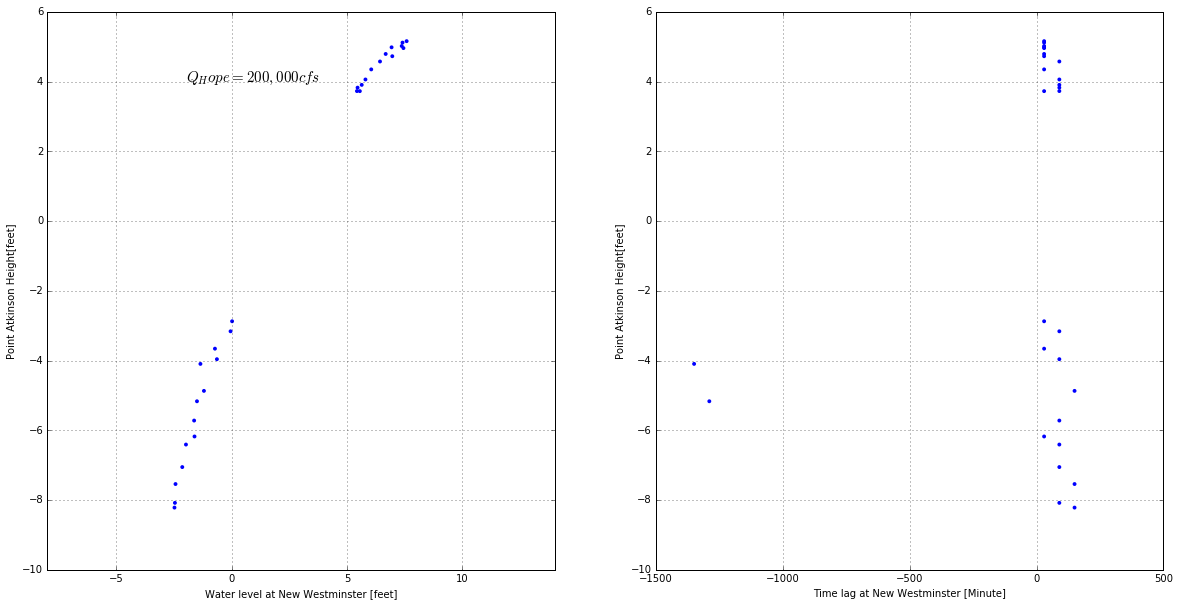

In [32]:
fig = plot_height_time_stn(ssh_model, ssh_obs, time_lag_mod, 'New Westminster')

* Mission

In [33]:
## grid cell for Mission is [151, 108]
mima, mimi, tmima, tmimi = readoff_stn_highlow_waterlevel_new(t_end, t_orig, 151, 108,ssh_mod, tt)

In [34]:
##combine both max and min water level for MISIION
ssh_model = []
ssh_model.append(mima)
ssh_model.append(mimi)

In [35]:
df = print_out_diff_wl(mima, mimi)
df

[9.2832458613738602,
 9.8456569710193964,
 9.5544258753458653,
 9.4941541738319266,
 9.4869994653726177,
 8.7685446441906869,
 7.8438128542712349,
 7.0015472064180937,
 5.898122868825757,
 5.6103519176247865,
 6.0589015092749605,
 6.4418137347291458,
 6.6365281075943168,
 7.019025527840367]

In [36]:
## average, max and min of the tidal amplitude at Mission
ddf = np.array(df)
mean_ddf_MI = np.mean(ddf)* 0.3048
max_ddf_MI = np.max(ddf)* 0.3048
min_ddf_MI = np.min(ddf)* 0.3048
print ('Max amplitude of model: {0:.4}'.format(max_ddf_MI))
print ('Min amplitude of model: {0:.4}'.format(min_ddf_MI))
print ('Mean amplitude of model: {0:.4}'.format(mean_ddf_MI))

Max amplitude of model: 3.001
Min amplitude of model: 1.71
Mean amplitude of model: 2.372


In [37]:
delta_max, delta_min = get_time_lag(tmimi, time_min, tmima, time_max)

* 190min delay for high water in the Ages model at Mission

In [38]:
delta_max

[30, 30, 90, 30, 30, 90, 30, 90, 90, 150, 90, 90, 150, 90]

* 370min delay for low water in the Ages model at Mission

In [39]:
delta_min

[210, 150, 150, -1230, -1290, -1290, -1290, 90, 90, 150, 150, 210, 210, 150]

In [40]:
##combine both time lag for high and low water level at Mission
time_lag_mod = []
time_lag_mod.append(delta_max)
time_lag_mod.append(delta_min)

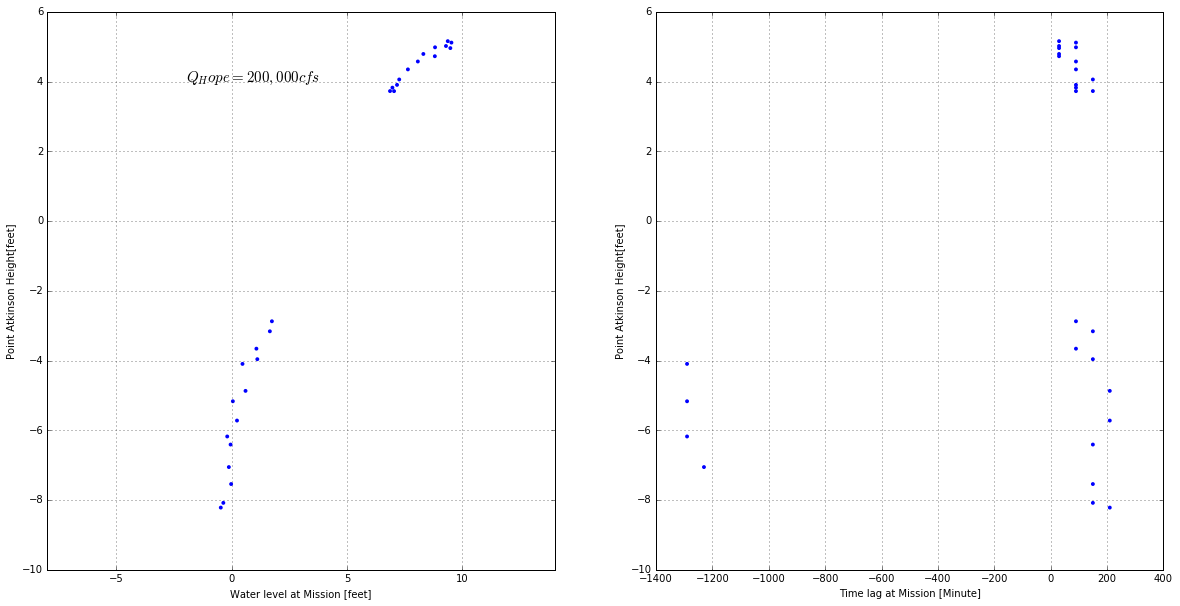

In [41]:
fig = plot_height_time_stn(ssh_model, ssh_obs, time_lag_mod, 'Mission')

* Tide nearly no dissipation

* Deas Island channel

In [42]:
## grid cell for Deas Island is [65,69]
mima, mimi, tmima, tmimi = readoff_stn_highlow_waterlevel_new(t_end, t_orig, 65, 69,ssh_mod, tt)

In [43]:
##combine both max and min water level for DEAS ISLAND
ssh_model = []
ssh_model.append(mima)
ssh_model.append(mimi)

In [44]:
df = print_out_diff_wl(mima, mimi)
df

[11.199445236386275,
 11.647417554705161,
 11.505492794232104,
 11.205801500735944,
 10.419019798594196,
 9.5487943315130508,
 8.0652077366986603,
 7.5534956035964438,
 6.6894846247250008,
 6.8373806051069046,
 7.499603461718622,
 8.1833629939812678,
 8.880841763313672,
 9.3361485035713585]

In [45]:
## average, max and min of the tidal amplitude at Deas Island channel for model
ddf = np.array(df)
mean_ddf_DI = np.mean(ddf)* 0.3048
max_ddf_DI = np.max(ddf)* 0.3048
min_ddf_DI = np.min(ddf)* 0.3048
print ('Max amplitude of model: {0:.4}'.format(max_ddf_DI))
print ('Min amplitude of model: {0:.4}'.format(min_ddf_DI))
print ('Mean amplitude of model: {0:.4}'.format(mean_ddf_DI))

Max amplitude of model: 3.55
Min amplitude of model: 2.039
Mean amplitude of model: 2.799


In [46]:
delta_max, delta_min = get_time_lag(tmimi, time_min, tmima, time_max)

* 10min delay at Deas Island for spring tide with tidal range of 5m at PA.

In [47]:
delta_max

[30, -30, 30, 30, -30, 30, 30, 30, 30, 30, 30, -30, 30, 30]

* 70min delay at Deas Island for neap tides with tidal range of 0.5m at PA.

In [48]:
delta_min

[30, 30, 90, 30, 30, 30, -30, 30, 30, 30, 30, 30, 30, 30]

In [49]:
##combine both time lag for high and low water level at Deas Island
time_lag_mod = []
time_lag_mod.append(delta_max)
time_lag_mod.append(delta_min)

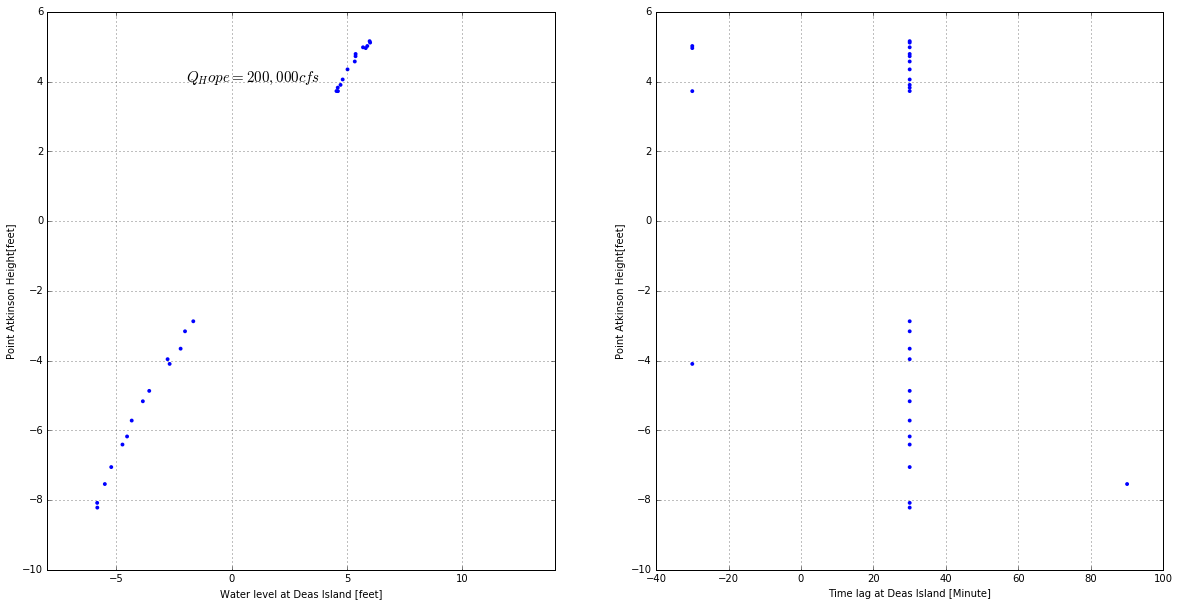

In [50]:
fig = plot_height_time_stn(ssh_model, ssh_obs, time_lag_mod, 'Deas Island')

* Steveston

In [51]:
## grid cell for Steveston Jetty is [75, 53]
mima, mimi, tmima, tmimi = readoff_stn_highlow_waterlevel_new(t_end, t_orig, 75, 53,ssh_mod, tt)

In [52]:
##combine both max and min water level for Steveston Jetty
ssh_model = []
ssh_model.append(mima)
ssh_model.append(mimi)

In [53]:
df = print_out_diff_wl(mima, mimi)
df

[11.77422213429228,
 12.179261117469606,
 12.045962212905483,
 11.42875728957609,
 10.896161237726687,
 9.7002421464194146,
 8.4157151187185839,
 7.3909655878237217,
 6.6535212001775506,
 7.1049598962303211,
 7.8241030375162754,
 8.6714260847236844,
 9.2954292228528512,
 9.9426531416224684]

In [54]:
## average, max and min of the tidal amplitude at Steveston for model
ddf = np.array(df)
mean_ddf_ST = np.mean(ddf)* 0.3048
max_ddf_ST = np.max(ddf)* 0.3048
min_ddf_ST = np.min(ddf)* 0.3048
print ('Max amplitude of model: {0:.4}'.format(max_ddf_ST))
print ('Min amplitude of model: {0:.4}'.format(min_ddf_ST))
print ('Mean amplitude of model: {0:.4}'.format(mean_ddf_ST))

Max amplitude of model: 3.712
Min amplitude of model: 2.028
Mean amplitude of model: 2.903


In [55]:
delta_max, delta_min = get_time_lag(tmimi, time_min, tmima, time_max)

* 5min delay at Steveston for spring tide with tidal range of 5m at PA.

In [56]:
delta_max

[-30, -30, 30, -30, -30, 30, -30, 30, -30, 30, 30, -30, 30, -30]

* 25min delay at Steveston for spring tide with tidal range of 5m at PA.

In [57]:
delta_min

[30, -30, 30, 30, -30, 30, -30, 30, 30, 30, -30, 30, 30, -30]

In [58]:
##combine both time lag for high and low water level at Steveston Jetty
time_lag_mod = []
time_lag_mod.append(delta_max)
time_lag_mod.append(delta_min)

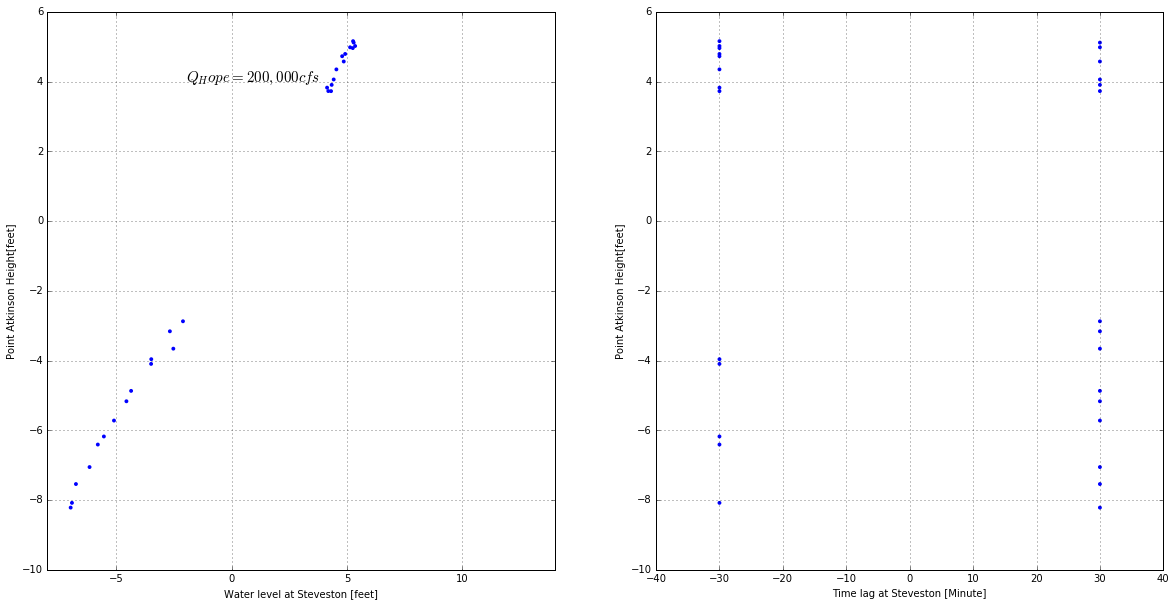

In [59]:
fig = plot_height_time_stn(ssh_model, ssh_obs, time_lag_mod, 'Steveston')

* Looks good at Steveston
* In this case, overdo the tide in the river, which seldom dissipate in the channel. Too high water level at Mission!

* Edge of new river channel model domain

In [60]:
## grid cell for edge of new river treatment is [151, 136]
mima, mimi, tmima, tmimi = readoff_stn_highlow_waterlevel_new(t_end, t_orig, 151, 136,ssh_mod, tt)

In [61]:
##combine both max and min water level for edge of model domain
ssh_model = []
ssh_model.append(mima)
ssh_model.append(mimi)

In [62]:
df = print_out_diff_wl(mima, mimi)
df

[8.873280401774279,
 9.3845045805133864,
 9.1190487537484142,
 9.2578797144057567,
 9.1423648666209125,
 8.4186919287746669,
 7.5191657335113664,
 6.7001649635670386,
 5.6596937298461842,
 5.4042268143551233,
 5.7599249630775358,
 6.1552239254390777,
 6.3860360679664003,
 6.6348534869396776]

In [63]:
## average, max and min of the tidal amplitude at edge of model domain 
ddf = np.array(df)
mean_ddf_ST = np.mean(ddf)* 0.3048
max_ddf_ST = np.max(ddf)* 0.3048
min_ddf_ST = np.min(ddf)* 0.3048
print ('Max amplitude of model: {0:.4}'.format(max_ddf_ST))
print ('Min amplitude of model: {0:.4}'.format(min_ddf_ST))
print ('Mean amplitude of model: {0:.4}'.format(mean_ddf_ST))

Max amplitude of model: 2.86
Min amplitude of model: 1.647
Mean amplitude of model: 2.273


In [64]:
delta_max, delta_min = get_time_lag(tmimi, time_min, tmima, time_max)

In [65]:
delta_max

[30, 30, 90, 90, 30, 90, 30, 90, 90, 150, 90, 90, 150, 90]

In [66]:
delta_min

[210, 150, 150, -1230, -1290, -1290, -1290, 90, 150, 210, 150, 210, 210, 150]

In [67]:
##combine both time lag for high and low water level at Steveston Jetty
time_lag_mod = []
time_lag_mod.append(delta_max)
time_lag_mod.append(delta_min)

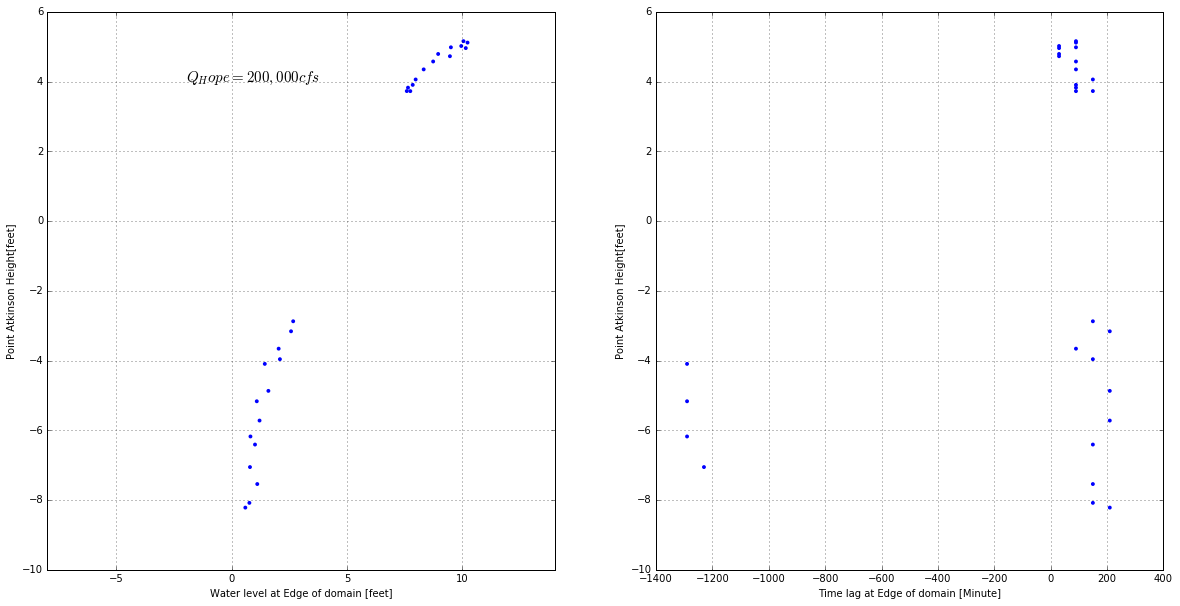

In [68]:
fig = plot_height_time_stn(ssh_model, ssh_obs, time_lag_mod, 'Edge of domain')

# New results in the Fraser River stations(with smoothed bathymetry6)

In [70]:
grid_T = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_NWSmoo/1hplumeT06160629smoo.nc')

In [72]:
t_orig, t_end, t_nemo = get_model_time_variables(grid_T)

In [73]:
ssh_zoom, time_zoom, t_orig, t_end = zoomin_period_tide(grid_T,'Point Atkinson', 0, MSL = 0)

In [74]:
ssh_max,ssh_min,time_max,time_min=find_highlow_tide(grid_T, ssh_zoom,time_zoom, t_end, t_orig, 0)

In [75]:
diff = print_out_diff_PA(ssh_max,ssh_min, meter =1)
diff ## tidal range at PA in  meters!!! June 24 has the smallest tidal range that I regard it as neap tide

[3.944944,
 3.9744409999999997,
 3.8581020000000001,
 3.7223330000000003,
 3.4125260000000002,
 3.0934720000000002,
 2.7087030000000003,
 2.509903,
 2.201384,
 2.2007780000000001,
 2.3974890000000002,
 2.6195279999999999,
 2.8796240000000002,
 3.1192619999999995]

In [76]:
##combine both max and min tidal anomaly for Point Atkinson
ssh_obs = []
ssh_obs.append(ssh_max)
ssh_obs.append(ssh_min)

In [77]:
ssh_mod = grid_T.variables['sossheig']
time_mod = grid_T.variables['time_counter'][:]

In [78]:
t = nc_tools.timestamp(grid_T, np.arange(time_mod.shape[0]))
for ind in range(len(t)):
    t[ind] = t[ind].datetime
tt = np.array(t) ## convert time_counter into datetime

* New Westminster

In [79]:
## use another time counts[69,106]
tma, tmi, ttma, ttmin = readoff_stn_highlow_waterlevel_new(t_end, t_orig, 69, 106,ssh_mod, tt)

In [80]:
##combine both max and min water level for NEW WESTMINSTER
ssh_model = []
ssh_model.append(tma)
ssh_model.append(tmi)

In [81]:
df = print_out_diff_wl(tma, tmi)
df

[9.4463899144976153,
 9.9100092342832262,
 9.845245697992679,
 9.7306367997422303,
 8.986762228600309,
 8.439783818452689,
 8.0343411154947244,
 7.1584405939722933,
 6.0345874802915871,
 5.8501509624457579,
 6.2796770255240242,
 6.7612294137008551,
 7.0614551543563682,
 7.4423595363386656]

In [82]:
## average, max and min of the tidal amplitude at NW
ddf = np.array(df)
mean_ddf_NW = np.mean(ddf)* 0.3048
max_ddf_NW = np.max(ddf)* 0.3048
min_ddf_NW = np.min(ddf)* 0.3048
print ('Max amplitude of model: {0:.4}'.format(max_ddf_NW))
print ('Min amplitude of model: {0:.4}'.format(min_ddf_NW))
print ('Mean amplitude of model: {0:.4}'.format(mean_ddf_NW))

Max amplitude of model: 3.021
Min amplitude of model: 1.783
Mean amplitude of model: 2.416


In [83]:
delta_max, delta_min = get_time_lag(ttmin, time_min, ttma, time_max)

In [84]:
delta_max

[30, 30, 30, 30, 30, 30, 30, 90, 30, 90, 90, 30, 90, 90]

In [85]:
delta_min

[150, 90, 150, 90, 30, -1290, -1350, 30, 30, 90, 90, 150, 90, 90]

* Mission

In [86]:
## grid cell for Mission is [151, 108]
mima, mimi, tmima, tmimi = readoff_stn_highlow_waterlevel_new(t_end, t_orig, 151, 108,ssh_mod, tt)

In [87]:
##combine both max and min water level for MISIION
ssh_model = []
ssh_model.append(mima)
ssh_model.append(mimi)

In [88]:
df = print_out_diff_wl(mima, mimi)
df

[9.2832458613738602,
 9.8456569710193964,
 9.5544258753458653,
 9.4941541738319266,
 9.4869994653726177,
 8.7685446441906869,
 7.8438128542712349,
 7.0015472064180937,
 5.898122868825757,
 5.6103519176247865,
 6.0589015092749605,
 6.4418137347291458,
 6.6365281075943168,
 7.019025527840367]

In [89]:
## average, max and min of the tidal amplitude at Mission
ddf = np.array(df)
mean_ddf_MI = np.mean(ddf)* 0.3048
max_ddf_MI = np.max(ddf)* 0.3048
min_ddf_MI = np.min(ddf)* 0.3048
print ('Max amplitude of model: {0:.4}'.format(max_ddf_MI))
print ('Min amplitude of model: {0:.4}'.format(min_ddf_MI))
print ('Mean amplitude of model: {0:.4}'.format(mean_ddf_MI))

Max amplitude of model: 3.001
Min amplitude of model: 1.71
Mean amplitude of model: 2.372


In [90]:
delta_max, delta_min = get_time_lag(tmimi, time_min, tmima, time_max)

In [91]:
delta_max

[30, 30, 90, 30, 30, 90, 30, 90, 90, 150, 90, 90, 150, 90]

In [92]:
delta_min

[210, 150, 150, -1230, -1290, -1290, -1290, 90, 90, 150, 150, 210, 210, 150]

* Deas Island

In [93]:
## grid cell for Deas Island is [65,69]
mima, mimi, tmima, tmimi = readoff_stn_highlow_waterlevel_new(t_end, t_orig, 65, 69,ssh_mod, tt)

In [94]:
##combine both max and min water level for Deas ISALND
ssh_model = []
ssh_model.append(mima)
ssh_model.append(mimi)

In [95]:
df = print_out_diff_wl(mima, mimi)
df

[11.199445236386275,
 11.647417554705161,
 11.505492794232104,
 11.205801500735944,
 10.419019798594196,
 9.5487943315130508,
 8.0652077366986603,
 7.5534956035964438,
 6.6894846247250008,
 6.8373806051069046,
 7.499603461718622,
 8.1833629939812678,
 8.880841763313672,
 9.3361485035713585]

In [96]:
## average, max and min of the tidal amplitude at Deas Island channel for model
ddf = np.array(df)
mean_ddf_DI = np.mean(ddf)* 0.3048
max_ddf_DI = np.max(ddf)* 0.3048
min_ddf_DI = np.min(ddf)* 0.3048
print ('Max amplitude of model: {0:.4}'.format(max_ddf_DI))
print ('Min amplitude of model: {0:.4}'.format(min_ddf_DI))
print ('Mean amplitude of model: {0:.4}'.format(mean_ddf_DI))

Max amplitude of model: 3.55
Min amplitude of model: 2.039
Mean amplitude of model: 2.799


In [97]:
delta_max, delta_min = get_time_lag(tmimi, time_min, tmima, time_max)

In [98]:
delta_max

[30, -30, 30, 30, -30, 30, 30, 30, 30, 30, 30, -30, 30, 30]

In [99]:
delta_min

[30, 30, 90, 30, 30, 30, -30, 30, 30, 30, 30, 30, 30, 30]

* Steveston 

In [100]:
## grid cell for Steveston Jetty is [75, 53]
mima, mimi, tmima, tmimi = readoff_stn_highlow_waterlevel_new(t_end, t_orig, 75, 53,ssh_mod, tt)

In [101]:
##combine both max and min water level for Steveston Jetty
ssh_model = []
ssh_model.append(mima)
ssh_model.append(mimi)

In [102]:
df = print_out_diff_wl(mima, mimi)
df

[11.77422213429228,
 12.179261117469606,
 12.045962212905483,
 11.42875728957609,
 10.896161237726687,
 9.7002421464194146,
 8.4157151187185839,
 7.3909655878237217,
 6.6535212001775506,
 7.1049598962303211,
 7.8241030375162754,
 8.6714260847236844,
 9.2954292228528512,
 9.9426531416224684]

In [103]:
## average, max and min of the tidal amplitude at Steveston for model
ddf = np.array(df)
mean_ddf_ST = np.mean(ddf)* 0.3048
max_ddf_ST = np.max(ddf)* 0.3048
min_ddf_ST = np.min(ddf)* 0.3048
print ('Max amplitude of model: {0:.4}'.format(max_ddf_ST))
print ('Min amplitude of model: {0:.4}'.format(min_ddf_ST))
print ('Mean amplitude of model: {0:.4}'.format(mean_ddf_ST))

Max amplitude of model: 3.712
Min amplitude of model: 2.028
Mean amplitude of model: 2.903


In [104]:
delta_max, delta_min = get_time_lag(tmimi, time_min, tmima, time_max)

In [105]:
delta_max

[-30, -30, 30, -30, -30, 30, -30, 30, -30, 30, 30, -30, 30, -30]

In [106]:
delta_min

[30, -30, 30, 30, -30, 30, -30, 30, 30, 30, -30, 30, 30, -30]

* Compared tidal heights and time lag results of smoothed bathymetry6 with original bathymetry6, there is very little difference, which could be considered as the same. Therefore, almost no difference was caused by smoothed/unsmoothed bathymetry6. 

# For nowcast results

* Deas Island

In [31]:
def readoff_stn_highlow_waterlevel_nowcast(tf, to, ssh_daily, tt):
    """This function was used to read through high and low water\
        levels at various stns during a time period, the water levels\
        returned are in feet unit instead of meters in nowcasts results"""
    ssh_mod_max = []
    ssh_mod_min = []
    time_mod_max = []
    time_mod_min = []
    j = 0
    for i in np.arange(tf.day - to.day +1):
        ssh_mod_max.append(max(ssh_daily[j:j+23])/0.3048)
        ssh_mod_min.append(min(ssh_daily[j:j+23])/0.3048)
        time_mod_max.append(tt[j:j+23][np.argmax(ssh_daily[j:j+23])])  
        time_mod_min.append(tt[j:j+23][np.argmin(ssh_daily[j:j+23])]) 
        ## need to convert time_mod_min in hour to date!!
        j = j +24
    return ssh_mod_max, ssh_mod_min, time_mod_max, time_mod_min 

In [25]:
to = datetime.datetime(2015,6,16)
tf = datetime.datetime(2015,6,29)
files = analyze.get_filenames(to,tf,'1h','grid_T','/data/dlatorne/MEOPAR/SalishSea/nowcast/')
##combine files
ssh_daily, time_daily = analyze.combine_files(files, 'sossheig',\
                                    'None',sites['Deas Island']['i'] + 349,sites['Deas Island']['j']+ 259)

In [27]:
now_ssh_max, now_ssh_min, t_now_max, t_now_min = \
readoff_stn_highlow_waterlevel_nowcast(tf, to,ssh_daily, tt)

In [29]:
##combine both max and min water level for Deas Island of nowcast
ssh_model = []
ssh_model.append(now_ssh_max)
ssh_model.append(now_ssh_min)

In [30]:
df = print_out_diff_wl(now_ssh_max, now_ssh_min)
df

[5.595015845899507,
 6.5110769034839988,
 6.9130362889037666,
 7.1768850831222029,
 6.8874876662658577,
 6.4792761730709723,
 6.2586505728678432,
 5.9011568171106612,
 5.1694538864720201,
 5.1036053227158042,
 5.5085854565729617,
 5.8998031605259946,
 6.1981347719515396,
 6.3906652056013193]

In [31]:
## average, max and min of the tidal amplitude at Deas Island of nowcast
ddf = np.array(df)
mean_ddf_DI_now = np.mean(ddf)* 0.3048
max_ddf_DI_now = np.max(ddf)* 0.3048
min_ddf_DI_now = np.min(ddf)* 0.3048
print ('Max amplitude of model: {0:.4}'.format(max_ddf_DI_now))
print ('Min amplitude of model: {0:.4}'.format(min_ddf_DI_now))
print ('Mean amplitude of model: {0:.4}'.format(mean_ddf_DI_now))

Max amplitude of model: 2.188
Min amplitude of model: 1.556
Mean amplitude of model: 1.872


In [32]:
delta_max, delta_min = get_time_lag(t_now_min, time_min, t_now_max, time_max)

* Same time lag phase with new model results

In [33]:
delta_max

[30, -30, 30, 30, -30, 30, 30, 30, 30, -30, 30, -30, 30, 30]

* More time lag than observations and new results, which should be around 40-50min for 3-4m tidal height at PA.

In [34]:
delta_min 

[150, 90, 90, 90, 30, 30, 30, 30, 30, 90, 30, 90, 90, 90]

* In summary, time lag of falling for low water level in Deas Island in nowcasts results is more than in the observations and new model results. Tidal range at Deas Island in the nowcasts is also too small which indicates tides dissipate too much and river not deep enough, so overall, the new river channel looks good for tide!

* Edge of river channel for nowcasts

In [32]:
to = datetime.datetime(2015,6,16)
tf = datetime.datetime(2015,6,29)
files = analyze.get_filenames(to,tf,'1h','grid_T','/data/dlatorne/MEOPAR/SalishSea/nowcast/')
##combine files
ssh_daily, time_daily = analyze.combine_files(files, 'sossheig',\
        'None',sites['nowcasts edge of domain']['i'] + 349,sites['nowcasts edge of domain']['j']+ 259)

In [33]:
now_ssh_max, now_ssh_min, t_now_max, t_now_min = \
readoff_stn_highlow_waterlevel_nowcast(tf, to,ssh_daily, tt)

In [34]:
##combine both max and min water level for edge of river channel of nowcast
ssh_model = []
ssh_model.append(now_ssh_max)
ssh_model.append(now_ssh_min)

In [35]:
df = print_out_diff_wl(now_ssh_max, now_ssh_min)
df

[5.0832624510517261,
 5.9603878695351558,
 6.3853622157507992,
 6.6591185710717991,
 6.3742350498483242,
 6.0777271073556003,
 5.8822624453800554,
 5.5171359144640091,
 4.8399528884512231,
 4.7378429747003272,
 5.1311036361640516,
 5.4680776811151226,
 5.7532034785024759,
 5.9432197078632241]

In [36]:
## average, max and min of the tidal amplitude at edge of river channel for nowcast
ddf = np.array(df)
mean_ddf_DI_now = np.mean(ddf)* 0.3048
max_ddf_DI_now = np.max(ddf)* 0.3048
min_ddf_DI_now = np.min(ddf)* 0.3048
print ('Max amplitude of model: {0:.4}'.format(max_ddf_DI_now))
print ('Min amplitude of model: {0:.4}'.format(min_ddf_DI_now))
print ('Mean amplitude of model: {0:.4}'.format(mean_ddf_DI_now))

Max amplitude of model: 2.03
Min amplitude of model: 1.444
Mean amplitude of model: 1.738


In [37]:
delta_max, delta_min = get_time_lag(t_now_min, time_min, t_now_max, time_max)

In [38]:
delta_max

[30, -30, 30, 30, -30, 30, 30, 30, 30, 30, 30, -30, 30, 30]

In [39]:
delta_min

[150, 90, 90, 90, 30, -1290, -1350, 30, 30, 90, 90, 90, 90, 90]

# Tidal heights inside Fraser River with shallowing of Mission to 3m

In [30]:
grid_T = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_Missionto3m/1hplume06160629Mission3mgridT.nc')

In [31]:
t_orig, t_end, t_nemo = figures.get_model_time_variables(grid_T)

In [32]:
ssh_zoom, time_zoom, t_orig, t_end = zoomin_period_tide(grid_T,'Point Atkinson', 0, MSL = 0)

In [33]:
ssh_max,ssh_min,time_max,time_min=find_highlow_tide(grid_T, ssh_zoom,time_zoom, t_end, t_orig, 0)

In [34]:
diff = print_out_diff_PA(ssh_max,ssh_min, meter =1)
diff

[3.8687930000000001,
 3.918593,
 3.8374999999999999,
 3.7140400000000002,
 3.42435,
 3.1029149999999999,
 2.7207910000000002,
 2.530821,
 2.2094269999999998,
 2.2002399999999995,
 2.4000440000000003,
 2.6093839999999999,
 2.867623,
 3.1096960000000005]

In [35]:
##combine both max and min tidal anomaly for Point Atkinson
ssh_obs = []
ssh_obs.append(ssh_max)
ssh_obs.append(ssh_min)

In [36]:
ssh_mod = grid_T.variables['sossheig']
time_mod = grid_T.variables['time_counter'][:]

In [37]:
t = nc_tools.timestamp(grid_T, np.arange(time_mod.shape[0]))
for ind in range(len(t)):
    t[ind] = t[ind].datetime
tt = np.array(t) ## convert time_counter into datetime

* Steveston jetty

In [38]:
##grid cell for Steveston jetty is [79,33]
mima, mimi, tmima, tmimi = readoff_stn_highlow_waterlevel_new(t_end,t_orig,79,33,ssh_mod,tt)

In [39]:
##combine both max and min water level for steveston jetty
ssh_model = []
ssh_model.append(mima)
ssh_model.append(mimi)

In [40]:
df = print_out_diff_wl(mima,mimi)
df

[11.79045579564853,
 12.205660421391485,
 12.087898617341448,
 11.40861373560948,
 10.819110501156704,
 9.6648254888889973,
 8.4595167104966364,
 7.4140725564456043,
 6.6603424902663146,
 7.019223855549269,
 7.6827594614404386,
 8.675307035446167,
 9.2481006318189962,
 9.9478204419293732]

In [41]:
## average, max and min of the tidal amplitude at STEVESTON JETTY for model
ddf = np.array(df)
mean_ddf_DI = np.mean(ddf)* 0.3048
max_ddf_DI = np.max(ddf)* 0.3048
min_ddf_DI = np.min(ddf)* 0.3048
print ('Max amplitude of model: {0:.4}'.format(max_ddf_DI))
print ('Min amplitude of model: {0:.4}'.format(min_ddf_DI))
print ('Mean amplitude of model: {0:.4}'.format(mean_ddf_DI))

Max amplitude of model: 3.72
Min amplitude of model: 2.03
Mean amplitude of model: 2.897


In [42]:
delta_max, delta_min = get_time_lag(tmimi, time_min, tmima, time_max)

In [43]:
delta_max

[-30, -30, 30, -30, -30, 30, -30, 30, -30, 30, 30, -30, 30, -30]

In [44]:
delta_min

[30, -30, -30, 30, -30, 30, -30, 30, 30, 30, -30, 30, -30, -30]

* Deas Island

In [36]:
## grid cell for Deas Island is [65,69]
mima, mimi, tmima, tmimi = readoff_stn_highlow_waterlevel_new(t_end, t_orig, 65, 69,ssh_mod, tt)

In [37]:
##combine both max and min water level for DEAS ISLAND
ssh_model = []
ssh_model.append(mima)
ssh_model.append(mimi)

In [38]:
df = print_out_diff_wl(mima, mimi)
df

[11.61805053395549,
 12.01319412922296,
 11.775470937643778,
 11.35792045455592,
 10.572795479942181,
 9.6167260267603112,
 8.1716561958858662,
 7.5528318957080991,
 6.7108750265101431,
 7.0264620652661858,
 7.6728818688805642,
 8.5092439582654489,
 9.2321473938899388,
 9.7041461724308853]

In [39]:
## average, max and min of the tidal amplitude at Deas Island channel for model
ddf = np.array(df)
mean_ddf_DI = np.mean(ddf)* 0.3048
max_ddf_DI = np.max(ddf)* 0.3048
min_ddf_DI = np.min(ddf)* 0.3048
print ('Max amplitude of model: {0:.4}'.format(max_ddf_DI))
print ('Min amplitude of model: {0:.4}'.format(min_ddf_DI))
print ('Mean amplitude of model: {0:.4}'.format(mean_ddf_DI))

Max amplitude of model: 3.662
Min amplitude of model: 2.045
Mean amplitude of model: 2.864


In [40]:
delta_max, delta_min = get_time_lag(tmimi, time_min, tmima, time_max)

In [41]:
delta_max

[-30, -30, 30, -30, -30, 30, -30, 30, 30, 30, 30, -30, 30, 30]

In [42]:
delta_min

[30, 30, -30, 30, -30, 30, -30, 30, 30, 30, 30, 30, 30, -30]

In [43]:
##combine both time lag for high and low water level at NEW WESTMINSTER
time_lag_mod = []
time_lag_mod.append(delta_max)
time_lag_mod.append(delta_min)

* New Westminster

In [20]:
## use another time counts[69,106]
tma, tmi, ttma, ttmin = readoff_stn_highlow_waterlevel_new(t_end, t_orig, 69, 106,ssh_mod, tt)

In [21]:
##combine both max and min water level for NEW WESTMINSTER
ssh_model = []
ssh_model.append(tma)
ssh_model.append(tmi)

In [22]:
df = print_out_diff_wl(tma, tmi)
df

[10.321799303915871,
 10.532328462976171,
 10.597079288302444,
 10.253029858346373,
 9.5669676860173531,
 8.5959651964543049,
 7.9083090692054565,
 7.3123511093182199,
 6.3917256911282774,
 6.3171840500174543,
 7.0587333457989327,
 7.6852463127121213,
 8.175167941984542,
 8.7895003829415383]

In [23]:
## average, max and min of the tidal amplitude at NW
ddf = np.array(df)
mean_ddf_NW = np.mean(ddf)* 0.3048
max_ddf_NW = np.max(ddf)* 0.3048
min_ddf_NW = np.min(ddf)* 0.3048
print ('Max amplitude of model: {0:.4}'.format(max_ddf_NW))
print ('Min amplitude of model: {0:.4}'.format(min_ddf_NW))
print ('Mean amplitude of model: {0:.4}'.format(mean_ddf_NW))

Max amplitude of model: 3.23
Min amplitude of model: 1.925
Mean amplitude of model: 2.602


In [24]:
delta_max, delta_min = get_time_lag(ttmin, time_min, ttma, time_max)

In [25]:
delta_max

[30, -30, 30, 30, -30, 30, 30, 30, 30, 30, 30, 30, 30, 30]

In [26]:
delta_min

[90, 90, 30, 90, 30, 30, -1350, 30, 30, 30, 30, 90, 90, 30]

In [27]:
##combine both time lag for high and low water level at NEW WESTMINSTER
time_lag_mod = []
time_lag_mod.append(delta_max)
time_lag_mod.append(delta_min)

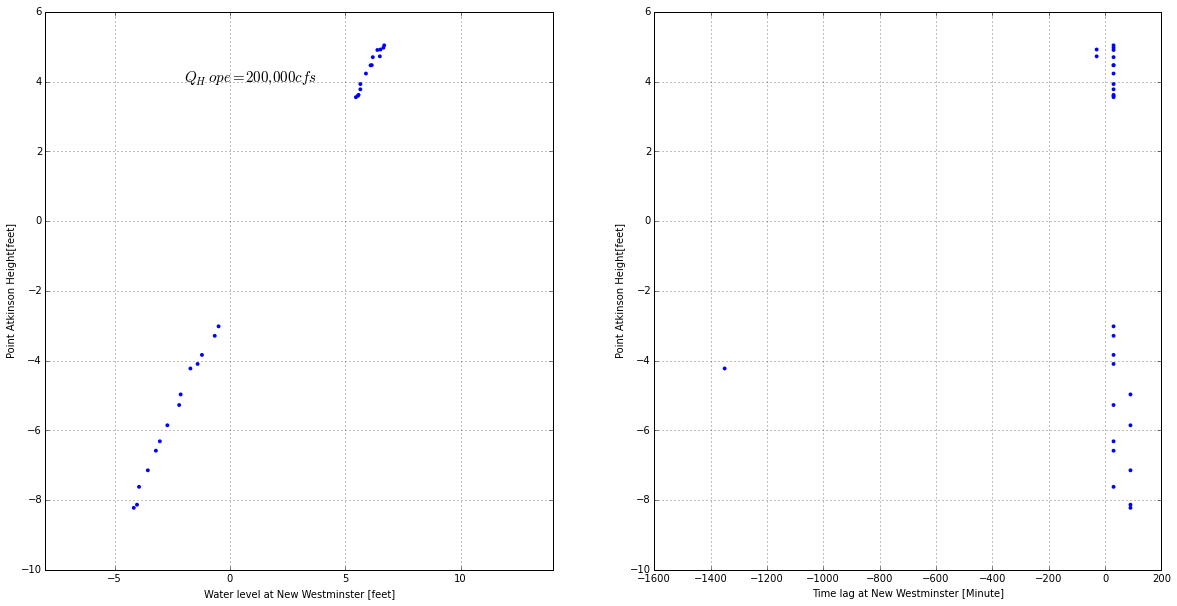

In [28]:
fig = plot_height_time_stn(ssh_model, ssh_obs, time_lag_mod, 'New Westminster')

* Mission

In [50]:
## grid cell for Mission is [151, 108]
mima, mimi, tmima, tmimi = readoff_stn_highlow_waterlevel_new(t_end, t_orig, 151, 108,ssh_mod, tt)

In [51]:
##combine both max and min water level for MISIION
ssh_model = []
ssh_model.append(mima)
ssh_model.append(mimi)

In [52]:
df = print_out_diff_wl(mima, mimi)
df

[0.66072452725387976,
 0.66626572546370966,
 0.68251385776389739,
 0.71365689355244299,
 0.68338211440038776,
 0.65777245468980539,
 0.64137726631064496,
 0.59500297536374092,
 0.54713778608427077,
 0.49685242920723027,
 0.52653429076427827,
 0.54571415808570123,
 0.54808895731848395,
 0.57151937109279061]

In [53]:
## average, max and min of the tidal amplitude at Mission
ddf = np.array(df)
mean_ddf_MI = np.mean(ddf)* 0.3048
max_ddf_MI = np.max(ddf)* 0.3048
min_ddf_MI = np.min(ddf)* 0.3048
print ('Max amplitude of model: {0:.4}'.format(max_ddf_MI))
print ('Min amplitude of model: {0:.4}'.format(min_ddf_MI))
print ('Mean amplitude of model: {0:.4}'.format(mean_ddf_MI))

Max amplitude of model: 0.2175
Min amplitude of model: 0.1514
Mean amplitude of model: 0.1859


In [54]:
delta_max, delta_min = get_time_lag(tmimi, time_min, tmima, time_max)

In [55]:
delta_max

[810, 210, 210, 210, 210, 210, 210, 270, 210, 210, 210, 210, 210, 210]

In [56]:
delta_min

[-1110,
 -1170,
 -1230,
 -1170,
 -1230,
 -1170,
 -1230,
 210,
 210,
 330,
 270,
 330,
 330,
 270]

* Edge of model domain in the 3m Mission new case

In [81]:
## grid cell for edge of new river treatment with Mission at 3m is [151, 136]
mima, mimi, tmima, tmimi = readoff_stn_highlow_waterlevel_new(t_end, t_orig, 151, 136,ssh_mod, tt)

In [84]:
tmima

[datetime.datetime(2015, 6, 16, 15, 30, tzinfo=tzutc()),
 datetime.datetime(2015, 6, 17, 6, 30, tzinfo=tzutc()),
 datetime.datetime(2015, 6, 18, 7, 30, tzinfo=tzutc()),
 datetime.datetime(2015, 6, 19, 7, 30, tzinfo=tzutc()),
 datetime.datetime(2015, 6, 20, 8, 30, tzinfo=tzutc()),
 datetime.datetime(2015, 6, 21, 9, 30, tzinfo=tzutc()),
 datetime.datetime(2015, 6, 22, 9, 30, tzinfo=tzutc()),
 datetime.datetime(2015, 6, 23, 10, 30, tzinfo=tzutc()),
 datetime.datetime(2015, 6, 24, 10, 30, tzinfo=tzutc()),
 datetime.datetime(2015, 6, 25, 11, 30, tzinfo=tzutc()),
 datetime.datetime(2015, 6, 26, 11, 30, tzinfo=tzutc()),
 datetime.datetime(2015, 6, 27, 12, 30, tzinfo=tzutc()),
 datetime.datetime(2015, 6, 28, 12, 30, tzinfo=tzutc()),
 datetime.datetime(2015, 6, 29, 13, 30, tzinfo=tzutc())]

In [45]:
df = print_out_diff_wl(mima, mimi)
df

[0.49697289003787404,
 0.48282734678173256,
 0.48360017340953121,
 0.51456330016528895,
 0.48892391635364163,
 0.45426248565433625,
 0.45081136107757658,
 0.43580538331680074,
 0.38666205769135686,
 0.34532991294160098,
 0.36537334362040141,
 0.38366148790975174,
 0.39727981947851276,
 0.3913881897613436]

In [46]:
## average, max and min of the tidal amplitude at edge of domain
ddf = np.array(df)
mean_ddf_MI = np.mean(ddf)* 0.3048
max_ddf_MI = np.max(ddf)* 0.3048
min_ddf_MI = np.min(ddf)* 0.3048
print ('Max amplitude of model: {0:.4}'.format(max_ddf_MI))
print ('Min amplitude of model: {0:.4}'.format(min_ddf_MI))
print ('Mean amplitude of model: {0:.4}'.format(mean_ddf_MI))

Max amplitude of model: 0.1568
Min amplitude of model: 0.1053
Mean amplitude of model: 0.1323


In [47]:
delta_max, delta_min = get_time_lag(tmimi, time_min, tmima, time_max)

In [48]:
delta_max

[810, 210, 270, 210, 210, 270, 210, 270, 210, 270, 210, 210, 210, 210]

In [49]:
delta_min

[-1110,
 -1170,
 -1170,
 -1170,
 -1170,
 -1110,
 -1170,
 210,
 270,
 -630,
 330,
 330,
 330,
 270]

* Relatively higher tidal amplitude in Deas Island, NW than observation, relatively lower tidal amplitude in Mission. Looks okay. But the ssh pcolorplot in the strait is too low which I am a little bit worry that the tides in the Fraser is good but in the strait are not.?

* It makes sense that water level at edge of model domain/Mission is high as in Ages paper, it argues that in freshet this should be the hydraulic grade line which is equal to water surface line and it should be around 3m higher than than at Sandheads or in the SoG. But our 3m bathymetry at Mission case makes it too high and if wanted to be accurate, tune back to around 6-8m at Mission, I guess, we will see how 8m at Mission works as follows.

# Tidal heights inside Fraser River with shallowing of Mission to 8m

In [48]:
grid_T = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14nor_Missionto8m/1hplume06160629Mission8mgridT.nc')

In [53]:
t_orig, t_end, t_nemo = figures.get_model_time_variables(grid_T)

In [54]:
ssh_zoom, time_zoom, t_orig, t_end = zoomin_period_tide(grid_T,'Point Atkinson', 0, MSL = 0)

In [55]:
ssh_max,ssh_min,time_max,time_min=find_highlow_tide(grid_T, ssh_zoom,time_zoom, t_end, t_orig, 0)

In [56]:
diff = print_out_diff_PA(ssh_max,ssh_min, meter =1)
diff

[3.8687930000000001,
 3.918593,
 3.8374999999999999,
 3.7140400000000002,
 3.42435,
 3.1029149999999999,
 2.7207910000000002,
 2.530821,
 2.2094269999999998,
 2.2002399999999995,
 2.4000440000000003,
 2.6093839999999999,
 2.867623,
 3.1096960000000005]

In [12]:
##combine both max and min tidal anomaly for Point Atkinson
ssh_obs = []
ssh_obs.append(ssh_max)
ssh_obs.append(ssh_min)

In [57]:
ssh_mod = grid_T.variables['sossheig']
time_mod = grid_T.variables['time_counter'][:]

In [58]:
t = nc_tools.timestamp(grid_T, np.arange(time_mod.shape[0]))
for ind in range(len(t)):
    t[ind] = t[ind].datetime
tt = np.array(t) ## convert time_counter into datetime

* Steveston Jetty

In [42]:
## grid cell for Steveston Jetty is [79, 33]
mima, mimi, tmima, tmimi = readoff_stn_highlow_waterlevel_new(t_end, t_orig, 79, 33,ssh_mod, tt)

In [43]:
##combine both max and min water level for STEESTON JETTY
ssh_model = []
ssh_model.append(mima)
ssh_model.append(mimi)

In [44]:
df = print_out_diff_wl(mima, mimi)
df

[11.786237319936276,
 12.198908748276278,
 12.084889052108203,
 11.394062614816379,
 10.797576172145332,
 9.6647668229000452,
 8.4514434882036333,
 7.4075490940274218,
 6.6583781574028995,
 7.0183305680908239,
 7.6695995067986917,
 8.657549231696942,
 9.2313929492720135,
 9.9383415825410779]

In [45]:
## average, max and min of the tidal amplitude at STEVESTON JETTY for model
ddf = np.array(df)
mean_ddf_DI = np.mean(ddf)* 0.3048
max_ddf_DI = np.max(ddf)* 0.3048
min_ddf_DI = np.min(ddf)* 0.3048
print ('Max amplitude of model: {0:.4}'.format(max_ddf_DI))
print ('Min amplitude of model: {0:.4}'.format(min_ddf_DI))
print ('Mean amplitude of model: {0:.4}'.format(mean_ddf_DI))

Max amplitude of model: 3.718
Min amplitude of model: 2.029
Mean amplitude of model: 2.895


In [46]:
delta_max, delta_min = get_time_lag(tmimi, time_min, tmima, time_max)

In [47]:
delta_max

[-30, -30, 30, -30, -30, 30, -30, 30, -30, 30, 30, -30, 30, -30]

In [48]:
delta_min

[30, -30, -30, 30, -30, 30, -30, 30, 30, 30, -30, 30, -30, -30]

* Deas Island

In [21]:
## grid cell for Deas Island is [65,69]
mima, mimi, tmima, tmimi = readoff_stn_highlow_waterlevel_new(t_end, t_orig, 65, 69,ssh_mod, tt)

In [22]:
##combine both max and min water level for DEAS ISLAND
ssh_model = []
ssh_model.append(mima)
ssh_model.append(mimi)

In [23]:
df = print_out_diff_wl(mima, mimi)
df

[11.239321291290242,
 11.69816676400152,
 11.478646455474411,
 11.111272601630745,
 10.381838077009505,
 9.4709848481526215,
 8.0260937529911835,
 7.4956071345512001,
 6.6557065082660181,
 6.879172886763345,
 7.5455011892819339,
 8.3165203179587213,
 9.0115679687089489,
 9.4525281369216785]

In [24]:
## average, max and min of the tidal amplitude at Deas Island channel for model
ddf = np.array(df)
mean_ddf_DI = np.mean(ddf)* 0.3048
max_ddf_DI = np.max(ddf)* 0.3048
min_ddf_DI = np.min(ddf)* 0.3048
print ('Max amplitude of model: {0:.4}'.format(max_ddf_DI))
print ('Min amplitude of model: {0:.4}'.format(min_ddf_DI))
print ('Mean amplitude of model: {0:.4}'.format(mean_ddf_DI))

Max amplitude of model: 3.566
Min amplitude of model: 2.029
Mean amplitude of model: 2.803


In [25]:
delta_max, delta_min = get_time_lag(tmimi, time_min, tmima, time_max)

In [26]:
delta_max

[-30, -30, 30, 30, -30, 30, -30, 30, 30, 30, 30, -30, 30, 30]

In [27]:
delta_min

[30, 30, -30, 30, 30, 30, -30, 30, 30, 30, 30, 30, 30, 30]

* New Westminster

In [28]:
## use another time counts[69,106]
tma, tmi, ttma, ttmin = readoff_stn_highlow_waterlevel_new(t_end, t_orig, 69, 106,ssh_mod, tt)

In [29]:
##combine both max and min water level for NEW WESTMINSTER
ssh_model = []
ssh_model.append(tma)
ssh_model.append(tmi)

In [30]:
df = print_out_diff_wl(tma, tmi)
df

[9.166345078488348,
 9.6008291081806494,
 9.4691953399362827,
 9.3993832041898102,
 8.7921360502718624,
 7.8070910740399295,
 7.6541989024855646,
 6.9570522804272761,
 6.0412623574883915,
 5.8747352567792248,
 6.4195803026827614,
 6.9950578680501518,
 7.4201317753378788,
 7.8604902260572569]

In [31]:
## average, max and min of the tidal amplitude at NW
ddf = np.array(df)
mean_ddf_NW = np.mean(ddf)* 0.3048
max_ddf_NW = np.max(ddf)* 0.3048
min_ddf_NW = np.min(ddf)* 0.3048
print ('Max amplitude of model: {0:.4}'.format(max_ddf_NW))
print ('Min amplitude of model: {0:.4}'.format(min_ddf_NW))
print ('Mean amplitude of model: {0:.4}'.format(mean_ddf_NW))

Max amplitude of model: 2.926
Min amplitude of model: 1.791
Mean amplitude of model: 2.383


In [32]:
delta_max, delta_min = get_time_lag(tmimi, time_min, tmima, time_max)

In [33]:
delta_max

[-30, -30, 30, 30, -30, 30, -30, 30, 30, 30, 30, -30, 30, 30]

In [34]:
delta_min

[30, 30, -30, 30, 30, 30, -30, 30, 30, 30, 30, 30, 30, 30]

* Mission

In [35]:
## grid cell for Mission is [151, 108]
mima, mimi, tmima, tmimi = readoff_stn_highlow_waterlevel_new(t_end, t_orig, 151, 108,ssh_mod, tt)

In [36]:
##combine both max and min water level for MISIION
ssh_model = []
ssh_model.append(mima)
ssh_model.append(mimi)

In [37]:
df = print_out_diff_wl(mima, mimi)
df

[4.3536972968284227,
 4.5271593285357854,
 4.8129319205997501,
 4.8998291567554624,
 4.7059693517960266,
 4.4907246205437517,
 4.160173452432387,
 3.7763332288096265,
 3.3226468431668028,
 3.0950971162851095,
 3.362899142613248,
 3.5344768227554679,
 3.6676098981241534,
 3.8545220855652813]

In [38]:
## average, max and min of the tidal amplitude at Mission
ddf = np.array(df)
mean_ddf_MI = np.mean(ddf)* 0.3048
max_ddf_MI = np.max(ddf)* 0.3048
min_ddf_MI = np.min(ddf)* 0.3048
print ('Max amplitude of model: {0:.4}'.format(max_ddf_MI))
print ('Min amplitude of model: {0:.4}'.format(min_ddf_MI))
print ('Mean amplitude of model: {0:.4}'.format(mean_ddf_MI))

Max amplitude of model: 1.493
Min amplitude of model: 0.9434
Mean amplitude of model: 1.231


In [39]:
delta_max, delta_min = get_time_lag(tmimi, time_min, tmima, time_max)

In [40]:
delta_max

[150, 90, 150, 150, 90, 150, 150, 150, 150, 150, 150, 150, 150, 150]

In [41]:
delta_min

[210,
 150,
 -1230,
 -1230,
 -1290,
 -1230,
 -1290,
 150,
 150,
 210,
 210,
 270,
 210,
 210]

* Edge of model domain

In [59]:
## grid cell for edge of new river treatment with Mission at 8m is [151, 136]
mima, mimi, tmima, tmimi = readoff_stn_highlow_waterlevel_new(t_end, t_orig, 151, 136,ssh_mod, tt)

In [60]:
##combine both max and min water level for edge of model domain
ssh_model = []
ssh_model.append(mima)
ssh_model.append(mimi)

In [61]:
df = print_out_diff_wl(mima, mimi)
df

[3.5676766881166788,
 3.8478584114335028,
 4.0774137329241729,
 4.1149208551942529,
 3.9640280205433758,
 3.7283737828412384,
 3.4929808043432367,
 3.1585322590324818,
 2.7696416759741265,
 2.6125099089514876,
 2.7810776327538687,
 2.9651112756704094,
 3.038983488958964,
 3.175069810211502]

In [62]:
## average, max and min of the tidal amplitude at edge of model domain with Mission of 8m
ddf = np.array(df)
mean_ddf_MI = np.mean(ddf)* 0.3048
max_ddf_MI = np.max(ddf)* 0.3048
min_ddf_MI = np.min(ddf)* 0.3048
print ('Max amplitude of model: {0:.4}'.format(max_ddf_MI))
print ('Min amplitude of model: {0:.4}'.format(min_ddf_MI))
print ('Mean amplitude of model: {0:.4}'.format(mean_ddf_MI))

Max amplitude of model: 1.254
Min amplitude of model: 0.7963
Mean amplitude of model: 1.03


In [63]:
delta_max, delta_min = get_time_lag(tmimi, time_min, tmima, time_max)

In [64]:
delta_max

[150, 150, 150, 150, 150, 150, 150, 210, 150, 210, 150, 150, 210, 150]

In [65]:
delta_min

[210,
 -1170,
 -1230,
 -1230,
 -1230,
 -1230,
 -1230,
 150,
 150,
 270,
 210,
 270,
 270,
 210]

* Shallowing Mission to 8 m decreased tidal height at Mission to about 1.2m, still around 0.9 m higher than observations, for Steveston Jetty is good, for Deas Island and New West, still 0.5m and 0.3m higher respectively. In a combination of Mission to 3 m where the tidal height at Mission is around 0.13 m which is 0.2 m lower than observations, the bathymetry after New West should be tunned around to 5m.

In [75]:
ssh= grid_T.variables['sossheig'][:]

(336, 170, 138)

<matplotlib.colorbar.Colorbar instance at 0x7f9f93651998>

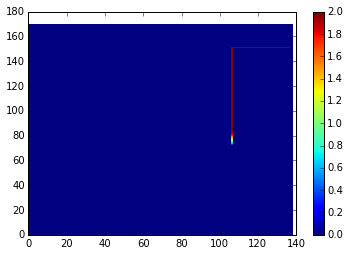

In [70]:
plt.pcolormesh(ssh[330, :,:],vmin=0, vmax=2)
plt.colorbar()

In [74]:
sshh= grid_TT.variables['sossheig'][:]

(336, 170, 138)

<matplotlib.colorbar.Colorbar instance at 0x7f9f85699950>

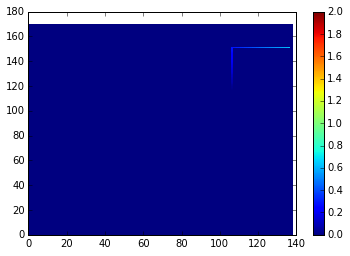

In [71]:
plt.pcolormesh(sshh[330, :,:],vmin=0, vmax=2)
plt.colorbar()

In [79]:
ssh[330:336, 151, 136]

array([ 6.38340378,  6.36870193,  6.35513306,  6.34521961,  6.33877468,
        6.33911419], dtype=float32)

In [80]:
sshh[330:336, 151, 136]

array([ 0.63660055,  0.43351197,  0.31260461,  0.33720028,  0.58867419,
        1.13223374], dtype=float32)